### Outline de la experimentación
- **DONE**: Explicar mas o menos como son los pasos, el ambiente de experimentación, las fuentes de datos y una descripción cauntitativa de la misma.
- **DONE**: Explicar datos de la batería + generadores. Quizas describir en la parte del modelo las ecuaciones que los dominan.
- Mostrar resultados para modelo solo con generación solar.
- Mostrar para solar + eolica.
- Concluir que la que va es solar + eólica.

In [48]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import math
from scipy.stats import describe, scoreatpercentile

In [49]:
# CONSTANTS
SIMULATION_DAYS = 7; TRANSPARENCY = .4

In [50]:
# Helper functions

def DEVSTimeToMinutes(aDEVSTime):
    """Converts a DEVS Timestamp into minutes."""
    START_YEAR = 1990
    
    splittedDate = aDEVSTime.split(':')
    # Normal assert
    hours = int(splittedDate[0])
    minutes = int(splittedDate[1])
    seconds = int(splittedDate[2])
    mseconds = int(splittedDate[3])
    
    return minutes + hours * 60

def format_date(x, pos=None):
    """Formats a minutes value into DEVS Time format."""
    hours = math.floor(x / 60)
    minutes = x - hours*60
    
    return '%02d:%02d:00:00' % (hours,minutes)

def daysToHours(someDays):
    """Converts days to minutes."""
    return someDays * 24 * 60

from collections import Iterable
def applyToAxis(axes, function):
    """Apply function to all matplotlib axis."""
    if isinstance(axes, Iterable):
        for axis in axes:
            applyToAxis(axis, function)
    elif isinstance(axes, matplotlib.axes.Axes):
        function(axes)
    else:
        raise Exception('anAxis in not an Axes. Its %s' % (str(axes.__class__)))

def setDailyVLines(axes):
    """Set a daily Vline in a matplotlib axis."""
    def doSetDailyVLines(anAxis):
        for day in range(7):
            anAxis.axvline(x=24*60*(day+1), color=(0,0,0,TRANSPARENCY), linewidth=.3)
    applyToAxis(axes, doSetDailyVLines)

In [51]:
def loadAllSimulationResults(simulationName):
    """Loads alll simulation data into global variables, to be used throughout the notebook."""
    outputFile = open('../simulation/src/out/' + simulationName, 'r')

    parsedOutput = []
    for line in outputFile:
        # Trim newline character from read line
        line = line[:-1]
        # Split by spaces
        splittedLine = line.split(' ')
        # Drop excedent emoty read par`bts
        splittedLine = [readPart for readPart in splittedLine if readPart != '']
        parsedOutput.append(splittedLine)

    parsedData = pd.DataFrame(data=parsedOutput, columns=['time', 'port', 'value'])
    parsedData.loc[:, 'value'] = parsedData.value.astype(float)
    parsedData.loc[:, 'time'] = parsedData.time.map(DEVSTimeToMinutes)

    global gridOutData
    global gridSellData
    global generatedSolarPower
    global generatedWindPower
    global batteryDemand
    global batteryState
    global chargeChanges
    global totalGeneration
    global normalizedSolar
    global normalizedWind
    
    gridOutData = parsedData[parsedData.port == 'grid_out']
    gridSellData = parsedData[parsedData.port == 'grid_sell']
    generatedSolarPower = parsedData[parsedData.port == 'solarpowerbeinggenerated']
    generatedWindPower = parsedData[parsedData.port == 'windpowerbeinggenerated']
    batteryDemand = parsedData[parsedData.port == 'controlbatterydemand']
    batteryState = parsedData[parsedData.port == 'controlbatterystate']

    columnMappers = {
        'time': DEVSTimeToMinutes,
        'charge': float
    }
    chargeChanges = pd.read_csv('../simulation/src/out/batteryChargeChanges_' + simulationName,\
                sep=';', usecols=[1,2], names=['time', 'charge'], converters=columnMappers)
    try:
        totalGeneration = [generatedSolarPower.value.iloc[i]+generatedWindPower.value.iloc[i] for i in range(len(generatedSolarPower.value))]
    except IndexError:
        totalGeneration = np.array(generatedSolarPower.value)
        
    normalizedSolar = [generatedSolarPower.value.iloc[i]/totalGeneration[i] for i in range(len(generatedSolarPower.value))]

    try:
        normalizedWind = [generatedWindPower.value.iloc[i]/totalGeneration[i] for i in range(len(generatedSolarPower.value))]
    except IndexError:
        pass

### Sólo generación solar, 1 semana
#### Comando ejecutado: 

```./bin/cd++ -e../eventGeneration/mergedData.ev -mmodels/justSolarControllerModel.ma -oout/justSolar1Week -lout/justSolar1Week.log -t168:00:00:00````


In [52]:
loadAllSimulationResults('solarAndWind1Week')

En esta primera simulación, se evalúa el comportamiento del sistema completo, pero solo utilizando el panel solar como fuente de generación.

Lo primero que es interesante notar, es como el comportamiento del panel varía congruentemente con el horario del día, teniendo su pico de generación cercano al mediodía, y disminuyendo para ambos extremos (noche y madrugada). Esto muestra cómo con un modelo muy simple, y datos tomados de su contraparte real, una simulación puede asemejarse mucho al comportamiento verídico.

Como hay una franja en específico durante la cual el generador produce, se puede notar cómo la carga de la batería fluctúa, pasando entre los estados de disponible, en el cual se habilita el consumo de la misma, a vacía. Esto se debe a que la generación del panel es suficiente para mantener la carga en la batería, y a la vez, suministrar la demanda impuesta.

Es posible que, modificando la instalación para que soporte un array de paneles, en vez de uno solo, la potencia generada crezca linealmente con la cantidad de ellos. De esta manera, podría soportar la carga, y a la vez, preservar la carga. 

Se puede ver también como los momentos de más generación no se corresponden los con los de menor consumo, situación en la que el panes *podría* llegar a abastecer la demanda impuesta, y cargar la batería en los momentos de mayor consumo (en la que por si mismo, no realiza mucho aporte). 

In [56]:
loadAllSimulationResults('justSolar1Week')

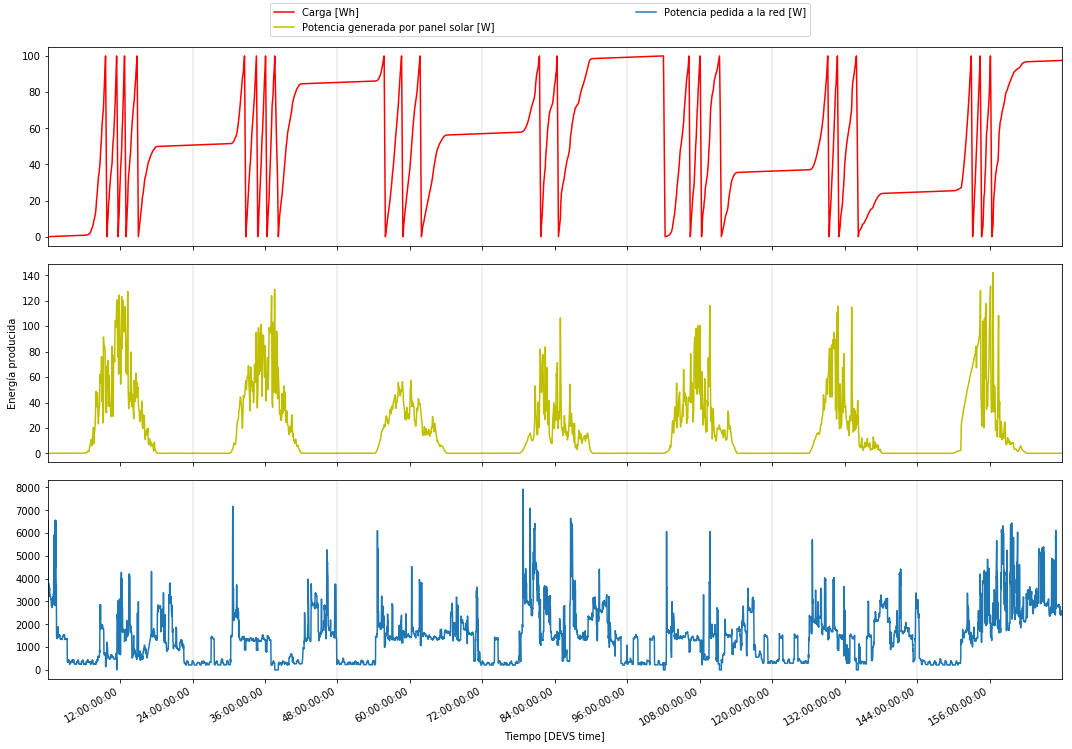

In [57]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (15,10))

ax[0].plot(chargeChanges.time, chargeChanges.charge, color='r', label='Carga [Wh]')

ax[1].plot(generatedSolarPower.time, generatedSolarPower.value, color='y', label='Potencia generada por panel solar [W]')
ax[1].set_ylabel('Energía producida')
        
setDailyVLines(ax)
applyToAxis(ax, lambda axes: axes.set_xlim(left=0, right=daysToHours(7)))
applyToAxis(ax, lambda axes: axes.set_xticks(np.arange(daysToHours(.5),daysToHours(SIMULATION_DAYS), daysToHours(.5))))

ax[2].plot(gridOutData.time, gridOutData.value, label='Potencia pedida a la red [W]')
ax[2].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[2].set_xlabel('Tiempo [DEVS time]')

# fig.legend(loc=(.76,.88))
fig.legend(bbox_to_anchor=(0.25, .99, .5, .102),ncol=2, mode="expand", borderaxespad=0.,loc=3)

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

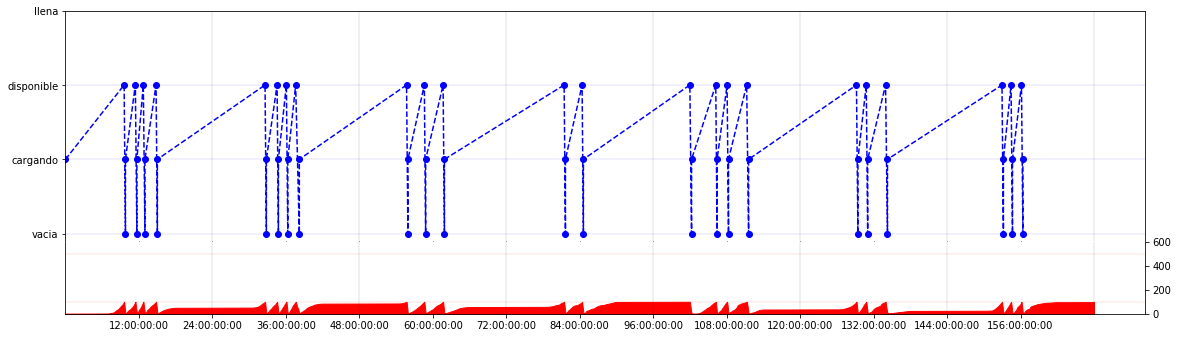

In [58]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize = (15,10))

setDailyVLines(ax)

batteryStatesLine = ax[0].plot(batteryState.time, batteryState.value, '--bo', label='Estado de la batería')

ax[0].set_xlim(left=0)
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[0].set_position(matplotlib.transforms.Bbox.from_bounds(0,0,1,.32))
ax[0].set_xticks(np.arange(daysToHours(.5),daysToHours(SIMULATION_DAYS), daysToHours(.5)))
batteryStates = [0,1,2,3] 
ax[0].set_yticks(batteryStates)
yAxisMap = {
    0: 'vacia',
    1: 'cargando',
    2: 'disponible',
    3: 'llena'
}

for state in batteryStates:
    ax[0].axhline(state, linewidth=.3, color=(0, 0, 1, TRANSPARENCY))

ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda aValue, tickPos: yAxisMap[aValue]))

# set the position of ax2 so that it is short (y2=0.32) but otherwise the same size as ax
ax[1].set_position(matplotlib.transforms.Bbox.from_bounds(0,-.101,1,.10))

batteryChargeLine = ax[1].fill_between(chargeChanges.time, chargeChanges.charge, color='r', label='Carga')

ax[1].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].yaxis.set_visible(True)
ax[1].yaxis.set_ticks_position('right')
ax[1].set_ylim(bottom=0,top=600)
ax[1].axhline(500, linewidth=.3, color=(1, 0, 0, TRANSPARENCY))
ax[1].axhline(100, linewidth=.3, color=(1, 0, 0, TRANSPARENCY))
plt.show()

### Sólo generación solar y eólica, 1 semana
#### Comando ejecutado: 

```./bin/cd++ -e../eventGeneration/mergedData.ev -mmodels/solarAndWindControllerModel.ma -oout/solarAndWind1Week -lout/solarAndWind1Week.log -t168:00:00:00```


In [59]:
loadAllSimulationResults('solarAndWind1Week')

En esta segunda simulación, se evalúa el mismo sistema, pero con ambos generadores.

Se puede ver la gran diferencia en la carga y la generación de ambas simulaciones. El aporte de la turbina eólica hace que el comportamiento del SmartGrid cambie radicalmente, pudiendo sumistrar la totalidad de la energía solicitada por intervalos extensos.

También se puede ver como a diferencia de la batería, en los instantes de menos consumo el sistema alcanza a soportar la totalidad del consumo de la instalación, produciendo un ahorro considerable (proyectando el mismo comportamiento a un mes, por ejemplo).

Hay momentos en los cuales la batería se encuentra llena, y permanece de esa manera durante un tiempo. Aquí surgen dos alternativas:
- Vender la energía excedente que esta siendo generada, lo cual es la ida central de un SmartGrid.
- Aumentar la capacidad de la batería, de manera de cargarla aún más, y autoabastecer la instalación por instantes de timpo aún mayores.

De ambas formas se produce un ahorro. Se podría establecer el costo de cada opción, y mediante simulaciones como esta (con alguna pequeña diferencia en los modelos) concluir cual es la más viable.

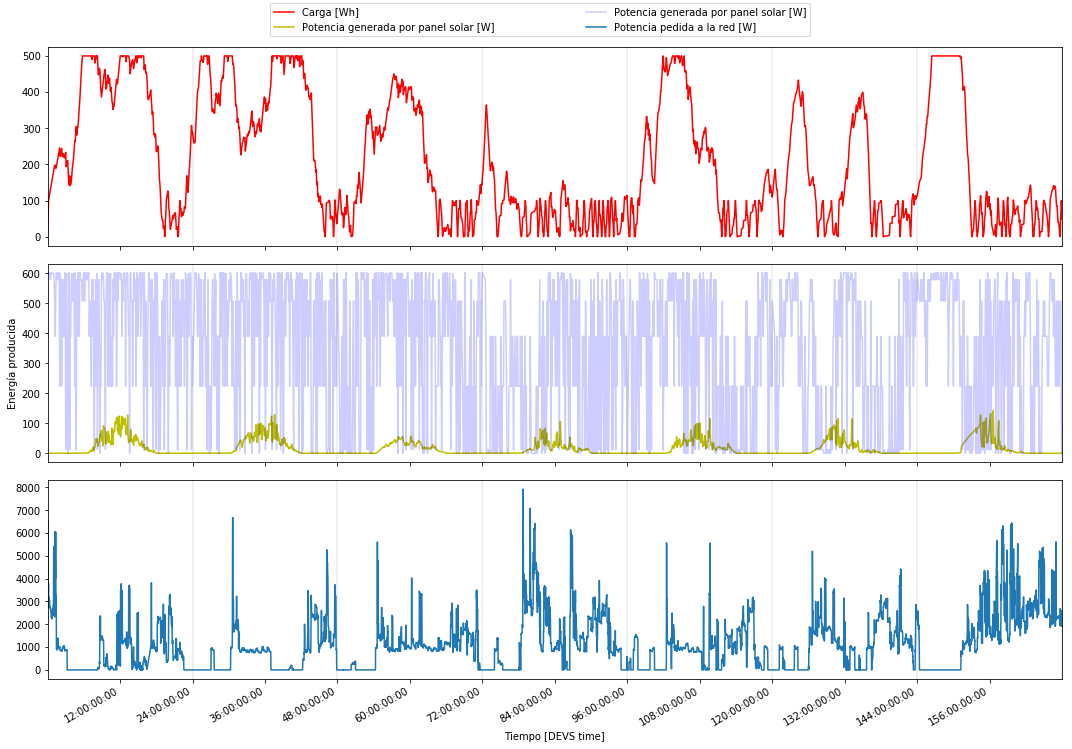

In [60]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (15,10))

ax[0].plot(chargeChanges.time, chargeChanges.charge, color='r', label='Carga [Wh]')

ax[1].plot(generatedSolarPower.time, generatedSolarPower.value, color='y', label='Potencia generada por panel solar [W]')
ax[1].plot(generatedSolarPower.time, generatedWindPower.value, color=(0,0,1,.2), label='Potencia generada por panel solar [W]')
ax[1].set_ylabel('Energía producida')
        
setDailyVLines(ax)
applyToAxis(ax, lambda axes: axes.set_xlim(left=0, right=daysToHours(7)))
applyToAxis(ax, lambda axes: axes.set_xticks(np.arange(daysToHours(.5),daysToHours(SIMULATION_DAYS), daysToHours(.5))))

ax[2].plot(gridOutData.time, gridOutData.value, label='Potencia pedida a la red [W]')
ax[2].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[2].set_xlabel('Tiempo [DEVS time]')

# fig.legend(loc=(.76,.88))
fig.legend(bbox_to_anchor=(0.25, .99, .5, .102),ncol=2, mode="expand", borderaxespad=0.,loc=3)

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

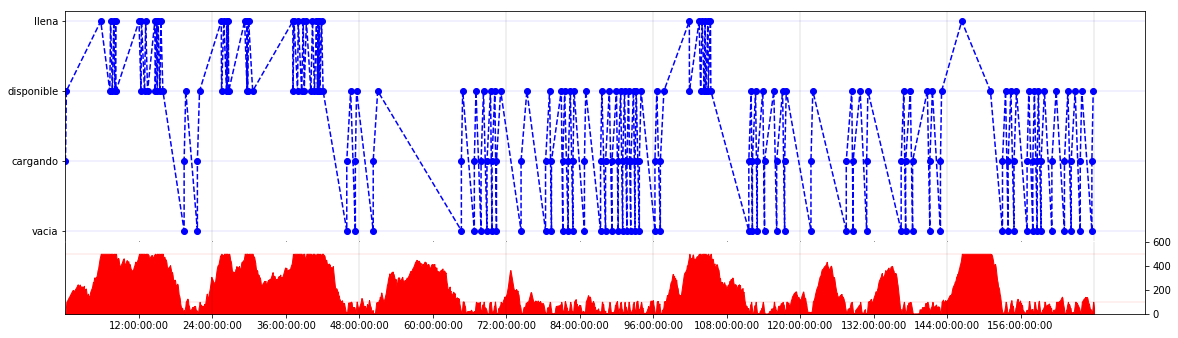

In [61]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize = (15,10))

setDailyVLines(ax)

batteryStatesLine = ax[0].plot(batteryState.time, batteryState.value, '--bo', label='Estado de la batería')

ax[0].set_xlim(left=0)
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[0].set_position(matplotlib.transforms.Bbox.from_bounds(0,0,1,.32))
ax[0].set_xticks(np.arange(daysToHours(.5),daysToHours(SIMULATION_DAYS), daysToHours(.5)))
batteryStates = [0,1,2,3] 
ax[0].set_yticks(batteryStates)
yAxisMap = {
    0: 'vacia',
    1: 'cargando',
    2: 'disponible',
    3: 'llena'
}

for state in batteryStates:
    ax[0].axhline(state, linewidth=.3, color=(0, 0, 1, TRANSPARENCY))

ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda aValue, tickPos: yAxisMap[aValue]))

# set the position of ax2 so that it is short (y2=0.32) but otherwise the same size as ax
ax[1].set_position(matplotlib.transforms.Bbox.from_bounds(0,-.101,1,.10))

batteryChargeLine = ax[1].fill_between(chargeChanges.time, chargeChanges.charge, color='r', label='Carga')

ax[1].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].yaxis.set_visible(True)
ax[1].yaxis.set_ticks_position('right')
ax[1].set_ylim(bottom=0,top=600)
ax[1].axhline(500, linewidth=.3, color=(1, 0, 0, TRANSPARENCY))
ax[1].axhline(100, linewidth=.3, color=(1, 0, 0, TRANSPARENCY))
plt.show()

### Qué generador vale más?

Si vemos cuánto generaron en cada instante ambos generadores de manera acumulada, lo primero que podemos notar es la variabilidad de los valores. Hay instantes en los que la potencia acumulada llega a los $650W$, mientras que al momento siguiente llega a casi 0. A priori uno pensaría que esto se debe a los datos, lo cual es en parte cierto, pero el problema va más alla de eso.
Como ambos generadores varían su potencia generada al recibir como evento un cambio en el estado meteorólogico de la simulación, de manera instantánea, esto da lugar a ciertas situaciones especiales, dadas por la forma en la que se realizaron las mediciones utilizada como eventos:
- Si en algún momento el instrumento para medir la radiación solar fue ocluído, esto dará lugar a una serie de mediciones en las cuales su valor disiminuyo significativamente, no representando la realidad.
- Cambios repentinos en la velocidad del viento, lo cual es normal, ya que el mismo puede tener un comportamiento compuesto por ráfagas.
- Problemas en los instrumentos, lo cual dará mediciones erróneas, o valores no consistentes.

Pero más allá de esto, esto podría solucionarse si los modelos de los generadores tuvieran algún tipo de inercia. Esto sería, algún tipo de resistencia al cambio repentino, no viendose su salida, o su estado interno afectado por que de un instante para el otro se recibió un evento qué indicaba que la velocidad del viento disminuyó a casi cero, y depués de este otro en el cual ya volvió al valor anterior (tomando como ejemplo el generador eólico). Aparte, el generador eólico es un caso especial, ya que físicamente poseé inercia (si su rotor está girando a una velocidad $V > 0$, el que la velocidad del viento disminuya a cero no hará que $V$ pase a valer cero en el acto).

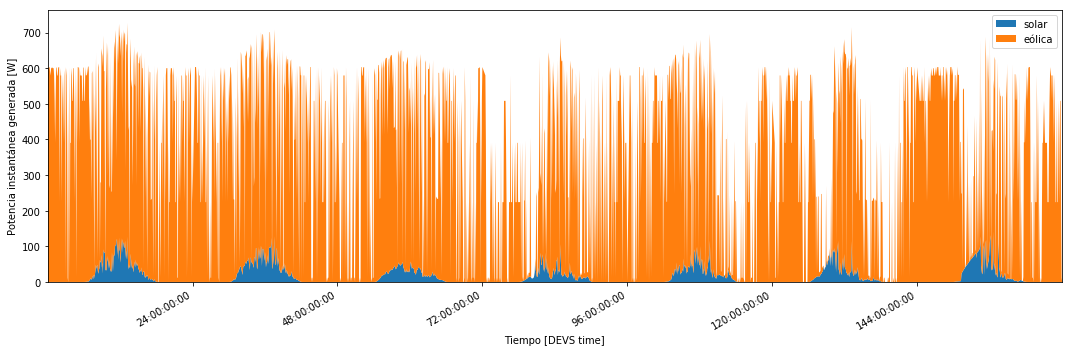

In [53]:
fig, ax = plt.subplots(figsize = (15,5))

ax.stackplot(generatedSolarPower.time, [generatedSolarPower.value, generatedWindPower.value], labels=["solar", "eólica"])

ax.set_xlim(left=0, right=7*24*60)

ax.set_xlabel('Tiempo [DEVS time]')
ax.set_ylabel('Potencia instantánea generada [W]')

ax.legend()

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.set_xticks(np.arange(daysToHours(1),daysToHours(SIMULATION_DAYS), daysToHours(1)))

ax.legend()

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [54]:
normalizedWindGeneration = np.array(generatedWindPower.value) / np.array(totalGeneration)
print('Stats description: ', describe(normalizedWindGeneration))
print('Value at .5-percentile: ', scoreatpercentile(normalizedWindGeneration, 50))

Stats description:  DescribeResult(nobs=1980, minmax=(0.0, 0.9998027282353501), mean=0.8316650623705086, variance=0.10322764600872694, skewness=-1.9618573475120162, kurtosis=2.163500095072692)
Value at .5-percentile:  0.9861050304036656


Si omitimos estas consideraciones, igual podemos notar la diferencia entre la potencia producida por el generador eólico y el solar. No solo en la intensidad de la misma, sino en la constancia. 

Por otro lado, como la fuente de energía del generador eólico no depende del horario del día (al menos no de manera directa), tiene un comportamiento mucho mas constante, generando valores parecidos en cualquier instante.

Si normalizamos los valores de producción de energía en cada instante, podemos ver qué porcentaje de lo generado corresponde a cada uno de los generadores. Como era de esperar, gran parte corresponde a la turbina eólica, cubriendo en promedio el $83,16\%$ de la energía producida. Más alla de esto, hay insttante en que casi la totalidad de la generación corresponde al panel solar. Esto puede deberse a los problemas descriptos anteriormente, pero hay instantes en los que por alrededor de una hora la velocidad del viento disminuyó significativamente, que pueden dar sentido a las observaciones.

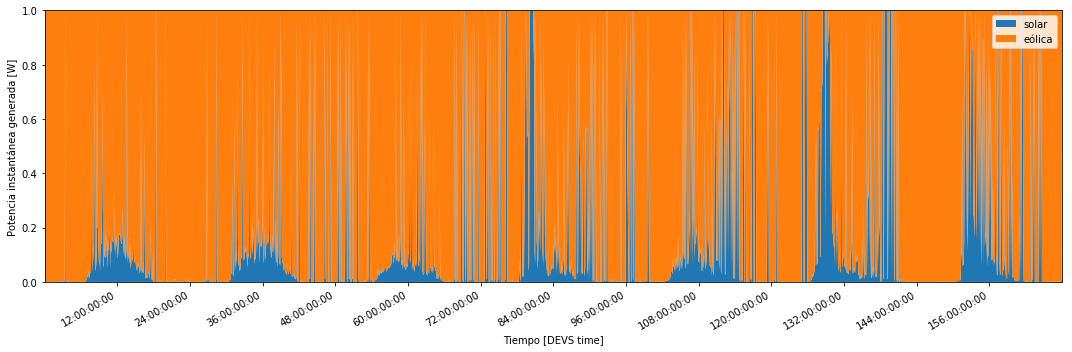

In [55]:
fig, ax = plt.subplots(figsize = (15,5))

ax.stackplot(generatedSolarPower.time, [normalizedSolar, normalizedWind], labels=["solar", "eólica"])

ax.set_xlim(left=0, right=7*24*60)
ax.set_ylim(bottom=0, top=1)

ax.set_xlabel('Tiempo [DEVS time]')
ax.set_ylabel('Potencia instantánea generada [W]')

ax.legend()

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.set_xticks(np.arange(daysToHours(.5),daysToHours(SIMULATION_DAYS), 12*60))

ax.legend()

fig.autofmt_xdate()

plt.tight_layout()
plt.show()